# How Spark Runs on a Cluster

Thus far in the book, we focused on Spark’s properties as a programming interface. We have discussed how the structured APIs take a logical operation, break it up into a logical plan, and convert that to a physical plan that actually consists of Resilient Distributed Dataset (RDD) operations that execute across the cluster of machines. This chapter focuses on what happens when Spark goes about executing that code. We discuss this in an implementation-agnostic way —this depends on neither the cluster manager that you’re using nor the code that you’re running.
At the end of the day, all Spark code runs the same way.

This chapter covers several key topics:
* The architecture and components of a Spark Application
* The life cycle of a Spark Application inside and outside of Spark
* Important low-level execution properties, such as pipelining
* What it takes to run a Spark Application, as a segue into Chapter 16.

Let’s begin with the architecture.

## The Architecture of a Spark Application
In Chapter 2, we discussed some of the high-level components of a Spark Application. Let’s review those again:

___The Spark driver___

The driver is the process “in the driver seat” of your Spark Application. It is the controller of the execution of a Spark Application and maintains all of the state of the Spark cluster (the state and tasks of the executors). It must interface with the cluster manager in order to actually get physical resources and launch executors. At the end of the day, this is just a process on a physical machine that is responsible for maintaining the state of the application running on the cluster.

___The Spark executors___

Spark executors are the processes that perform the tasks assigned by the Spark driver.
Executors have one core responsibility: take the tasks assigned by the driver, run them, and report back their state (success or failure) and results. Each Spark Application has its own separate executor processes.

___The cluster manager___

The Spark Driver and Executors do not exist in a void, and this is where the cluster manager comes in. The cluster manager is responsible for maintaining a cluster of machines that will run your Spark Application(s). Somewhat confusingly, a cluster manager will have its own “driver” (sometimes called master) and “worker” abstractions. The core difference is that these are tied to physical machines rather than processes (as they are in Spark). Figure 15-1 shows a basic cluster setup. The machine on the left of the illustration is the Cluster Manager Driver Node. The circles represent daemon processes running on and managing each of the individual worker nodes. There is no Spark Application running as of yet—these are just the processes from the cluster manager.
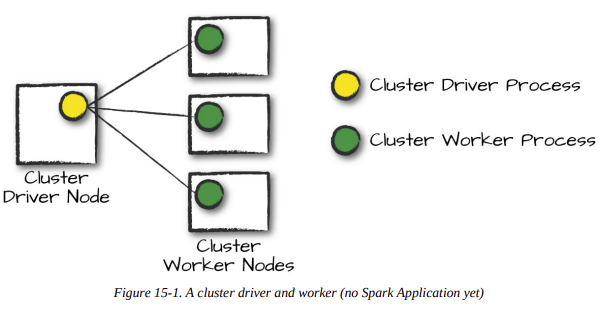
When it comes time to actually run a Spark Application, we request resources from the cluster manager to run it. Depending on how our application is configured, this can include a place to run the Spark driver or might be just resources for the executors for our Spark Application. Over the course of Spark Application execution, the cluster manager will be responsible for managing the underlying machines that our application is running on.

Spark currently supports three cluster managers: a simple built-in standalone cluster manager, Apache Mesos, and Hadoop YARN. However, this list will continue to grow, so be sure to check the documentation for your favorite cluster manager.

Now that we’ve covered the basic components of an application, let’s walk through one of the first choices you will need to make when running your applications: choosing the execution mode.

## Execution Modes
An execution mode gives you the power to determine where the aforementioned resources are
physically located when you go to run your application. You have three modes to choose from:
* Cluster mode
* Client mode
* Local mode

We will walk through each of these in detail using Figure 15-1 as a template. In the following section, rectangles with solid borders represent Spark driver process whereas those with dotted borders represent the executor processes.

#### Cluster mode
Cluster mode is probably the most common way of running Spark Applications. In cluster mode,a user submits a pre-compiled JAR, Python script, or R script to a cluster manager. The cluster manager then launches the driver process on a worker node inside the cluster, in addition to the executor processes. This means that the cluster manager is responsible for maintaining all Spark Application–related processes. Figure 15-2 shows that the cluster manager placed our driver on a worker node and the executors on other worker nodes.
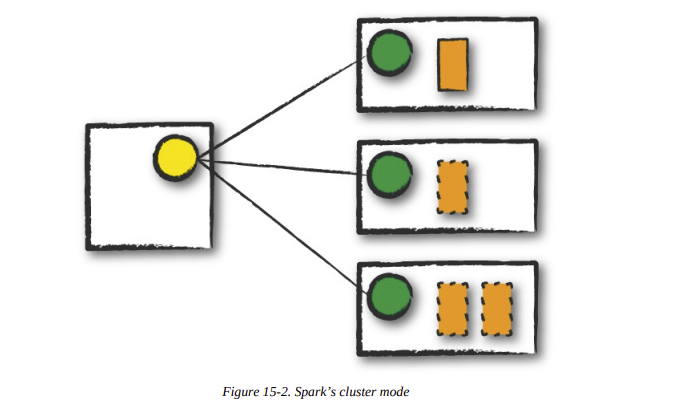
#### Client mode
Client mode is nearly the same as cluster mode except that the Spark driver remains on the client machine that submitted the application. This means that the client machine is responsible for maintaining the Spark driver process, and the cluster manager maintains the executor processses.
In Figure 15-3, we are running the Spark Application from a machine that is not colocated on the cluster. These machines are commonly referred to as gateway machines or edge nodes. In Figure 15-3, you can see that the driver is running on a machine outside of the cluster but that the workers are located on machines in the cluster.
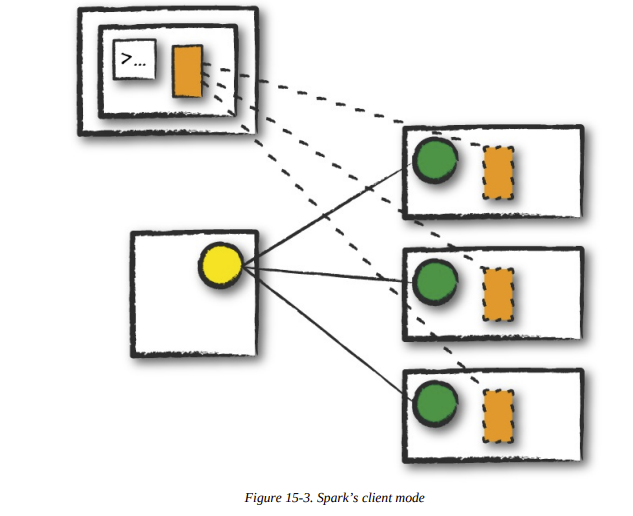
#### Local mode
Local mode is a significant departure from the previous two modes: it runs the entire Spark Application on a single machine. It achieves parallelism through threads on that single machine.
This is a common way to learn Spark, to test your applications, or experiment iteratively with local development. However, we do not recommend using local mode for running production applications.

## The Life Cycle of a Spark Application (Outside Spark)
This chapter has thus far covered the vocabulary necessary for discussing Spark Applications.
It’s now time to talk about the overall life cycle of Spark Applications from “outside” the actual Spark code. We will do this with an illustrated example of an application run with sparksubmit (introduced in Chapter 3). We assume that a cluster is already running with four nodes, a driver (not a Spark driver but cluster manager driver) and three worker nodes. The actual cluster manager does not matter at this point: this section uses the vocabulary from the previous section to walk through a step-by-step Spark Application life cycle from initialization to program exit.

NOTE

This section also makes use of illustrations and follows the same notation that we introduced previously. Additionally, we now introduce lines that represent network communication. Darker arrows represent communication by Spark or Spark-related processes, whereas dashed lines represent more general communication (like cluster management communication).

### Client Request
The first step is for you to submit an actual application. This will be a pre-compiled JAR or library. At this point, you are executing code on your local machine and you’re going to make a request to the cluster manager driver node (Figure 15-4). Here, we are explicitly asking for resources for the Spark driver process only. We assume that the cluster manager accepts this offer and places the driver onto a node in the cluster. The client process that submitted the original job exits and the application is off and running on the cluster.
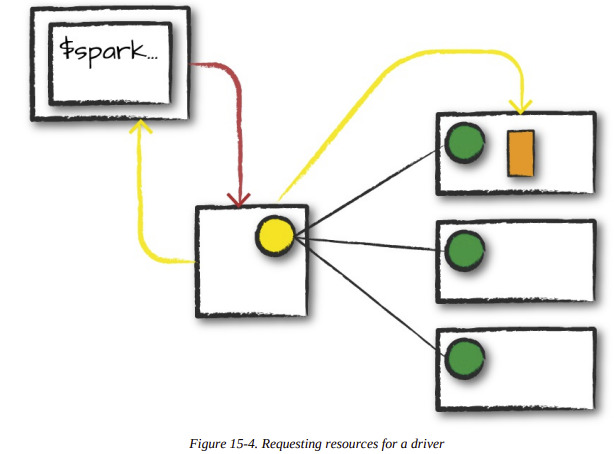
To do this, you’ll run something like the following command in your terminal:
~~~
./bin/spark-submit \
--class <main-class> \
--master <master-url> \
--deploy-mode cluster \
--conf <key>=<value> \
... # other options
<application-jar> \
[application-arguments]
~~~
### Launch
Now that the driver process has been placed on the cluster, it begins running user code
(Figure 15-5). This code must include a SparkSession that initializes a Spark cluster (e.g., driver + executors). The SparkSession will subsequently communicate with the cluster manager (the darker line), asking it to launch Spark executor processes across the cluster (the lighter lines). The number of executors and their relevant configurations are set by the user via the command-line arguments in the original spark-submit call.
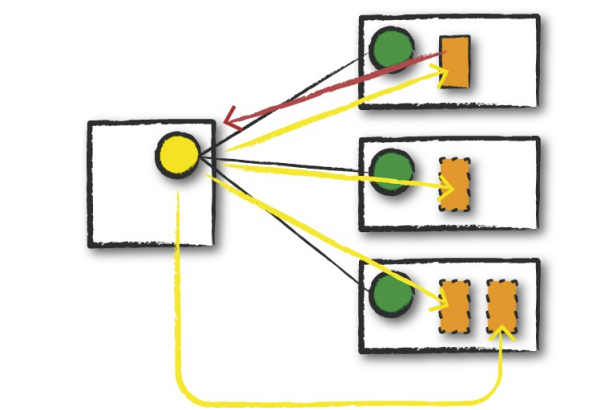
Figure 15-5. Launching the Spark Application

The cluster manager responds by launching the executor processes (assuming all goes well) and sends the relevant information about their locations to the driver process. After everything is hooked up correctly, we have a “Spark Cluster” as you likely think of it today.
### Execution
Now that we have a “Spark Cluster,” Spark goes about its merry way executing code, as shown in Figure 15-6. The driver and the workers communicate among themselves, executing code and moving data around. The driver schedules tasks onto each worker, and each worker responds with the status of those tasks and success or failure. (We cover these details shortly.)
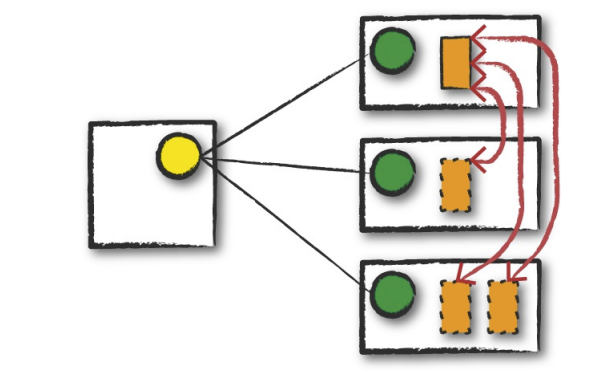
Figure 15-6. Application execution
### Completion
After a Spark Application completes, the driver processs exits with either success or failure (Figure 15-7). The cluster manager then shuts down the executors in that Spark cluster for the driver. At this point, you can see the success or failure of the Spark Application by asking the cluster manager for this information.
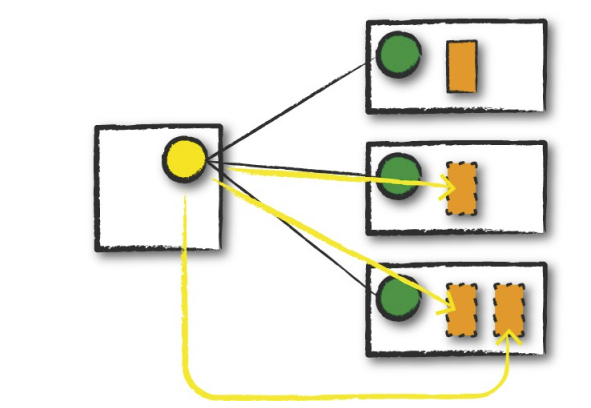
Figure 15-7. Shutting down the application

## The Life Cycle of a Spark Application (Inside Spark)
We just examined the life cycle of a Spark Application outside of user code (basically the infrastructure that supports Spark), but it’s arguably more important to talk about what happens within Spark when you run an application. This is “user-code” (the actual code that you write that defines your Spark Application). Each application is made up of one or more Spark jobs.
Spark jobs within an application are executed serially (unless you use threading to launch multiple actions in parallel).
### The SparkSession
The first step of any Spark Application is creating a SparkSession. In many interactive modes,this is done for you, but in an application, you must do it manually.
Some of your legacy code might use the new SparkContext pattern. This should be avoided in favor of the builder method on the SparkSession, which more robustly instantiates the Spark and SQL Contexts and ensures that there is no context conflict, given that there might be multiple libraries trying to create a session in the same Spark Appication:
~~~
// Creating a SparkSession in Scala
import org.apache.spark.sql.SparkSession
val spark = SparkSession.builder().appName("Databricks Spark Example")
  .config("spark.sql.warehouse.dir", "/user/hive/warehouse")
  .getOrCreate()
  ~~~

In [1]:
# Creating a SparkSession in Python
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local").appName("Word Count")\
  .config("spark.some.config.option", "some-value")\
  .getOrCreate()

After you have a SparkSession, you should be able to run your Spark code. From the
SparkSession, you can access all of low-level and legacy contexts and configurations
accordingly, as well. Note that the SparkSession class was only added in Spark 2.X. Older code you might find would instead directly create a SparkContext and a SQLContext for the
structured APIs.
#### The SparkContext
A SparkContext object within the SparkSession represents the connection to the Spark cluster.
This class is how you communicate with some of Spark’s lower-level APIs, such as RDDs. It is commonly stored as the variable sc in older examples and documentation. Through a
SparkContext, you can create RDDs, accumulators, and broadcast variables, and you can run
code on the cluster.

For the most part, you should not need to explicitly initialize a SparkContext; you should just be able to access it through the SparkSession. If you do want to, you should create it in the most general way, through the getOrCreate method:
~~~
// in Scala
import org.apache.spark.SparkContext
val sc = SparkContext.getOrCreate()
~~~

### THE SPARKSESSION, SQLCONTEXT, AND HIVECONTEXT
In previous versions of Spark, the SQLContext and HiveContext provided the ability to
work with DataFrames and Spark SQL and were commonly stored as the variable
sqlContext in examples, documentation, and legacy code. As a historical point, Spark 1.X
had effectively two contexts. The SparkContext and the SQLContext. These two each
performed different things. The former focused on more fine-grained control of Spark’s
central abstractions, whereas the latter focused on the higher-level tools like Spark SQL. In Spark 2.X, the communtiy combined the two APIs into the centralized SparkSession that we have today. However, both of these APIs still exist and you can access them via the SparkSession. It is important to note that you should never need to use the SQLContext and rarely need to use the SparkContext.

After you initialize your SparkSession, it’s time to execute some code. As we know from
previous chapters, all Spark code compiles down to RDDs. Therefore, in the next section, we will take some logical instructions (a DataFrame job) and walk through, step by step, what happens over time.

## Logical Instructions
As you saw in the beginning of the book, Spark code essentially consists of transformations and actions. How you build these is up to you—whether it’s through SQL, low-level RDD manipulation, or machine learning algorithms. Understanding how we take declarative instructions like DataFrames and convert them into physical execution plans is an important step to understanding how Spark runs on a cluster. In this section, be sure to run this in a fresh environment (a new Spark shell) to follow along with the job, stage, and task numbers.
### Logical instructions to physical execution
We mentioned this in Part II, but it’s worth reiterating so that you can better understand how Spark takes your code and actually runs the commands on the cluster. We will walk through some more code, line by line, explain what’s happening behind the scenes so that you can walk away with a better understanding of your Spark Applications. In later chapters, when we discuss monitoring, we will perform a more detailed tracking of a Spark job through the Spark UI. In this current example, we’ll take a simpler approach. We are going to do a three-step job: using a simple DataFrame, we’ll repartition it, perform a value-by-value manipulation, and then aggregate some values and collect the final result.

NOTE

This code was written and runs with Spark 2.2 in Python (you’ll get the same result in Scala, so we’ve omitted it). The number of jobs is unlikely to change drastically but there might be improvements to Spark’s underlying optimizations that change physical execution strategies.

In [2]:
# in Python
df1 = spark.range(2, 10000000, 2)
df2 = spark.range(2, 10000000, 4)
step1 = df1.repartition(5)
step12 = df2.repartition(6)
step2 = step1.selectExpr("id * 5 as id")
step3 = step2.join(step12, ["id"])
step4 = step3.selectExpr("sum(id)")
step4.collect() # 2500000000000

[Row(sum(id)=2500000000000)]

When you run this code, we can see that your action triggers one complete Spark job. Let’s take a look at the explain plan to ground our understanding of the physical execution plan. We can access this information on the SQL tab (after we actually run a query) in the Spark UI, as well:

In [3]:
step4.explain()

== Physical Plan ==
*(7) HashAggregate(keys=[], functions=[sum(id#8L)])
+- Exchange SinglePartition, ENSURE_REQUIREMENTS, [id=#66]
   +- *(6) HashAggregate(keys=[], functions=[partial_sum(id#8L)])
      +- *(6) Project [id#8L]
         +- *(6) SortMergeJoin [id#8L], [id#2L], Inner
            :- *(3) Sort [id#8L ASC NULLS FIRST], false, 0
            :  +- Exchange hashpartitioning(id#8L, 200), ENSURE_REQUIREMENTS, [id=#50]
            :     +- *(2) Project [(id#0L * 5) AS id#8L]
            :        +- Exchange RoundRobinPartitioning(5), REPARTITION_WITH_NUM, [id=#46]
            :           +- *(1) Range (2, 10000000, step=2, splits=1)
            +- *(5) Sort [id#2L ASC NULLS FIRST], false, 0
               +- Exchange hashpartitioning(id#2L, 200), ENSURE_REQUIREMENTS, [id=#57]
                  +- Exchange RoundRobinPartitioning(6), REPARTITION_WITH_NUM, [id=#56]
                     +- *(4) Range (2, 10000000, step=4, splits=1)




What you have when you call collect (or any action) is the execution of a Spark job that
individually consist of stages and tasks. Go to localhost:4040 if you are running this on your local machine to see the Spark UI. We will follow along on the “jobs” tab eventually jumping to stages and tasks as we proceed to further levels of detail.

## A Spark Job
In general, there should be one Spark job for one action. Actions always return results. Each job breaks down into a series of stages, the number of which depends on how many shuffle operations need to take place.

This job breaks down into the following stages and tasks:
* Stage 1 with 8 Tasks
* Stage 2 with 8 Tasks
* Stage 3 with 6 Tasks
* Stage 4 with 5 Tasks
* Stage 5 with 200 Tasks
* Stage 6 with 1 Task

I hope you’re at least somewhat confused about how we got to these numbers so that we can take the time to better understand what is going on!

## Stages
Stages in Spark represent groups of tasks that can be executed together to compute the same operation on multiple machines. In general, Spark will try to pack as much work as possible (i.e.,as many transformations as possible inside your job) into the same stage, but the engine starts new stages after operations called shuffles. A shuffle represents a physical repartitioning of the data—for example, sorting a DataFrame, or grouping data that was loaded from a file by key (which requires sending records with the same key to the same node). This type of repartitioning requires coordinating across executors to move data around. Spark starts a new stage after each shuffle, and keeps track of what order the stages must run in to compute the final result.

In the job we looked at earlier, the first two stages correspond to the range that you perform in order to create your DataFrames. By default when you create a DataFrame with range, it has eight partitions. The next step is the repartitioning. This changes the number of partitions by shuffling the data. These DataFrames are shuffled into six partitions and five partitions, corresponding to the number of tasks in stages 3 and 4.

Stages 3 and 4 perform on each of those DataFrames and the end of the stage represents the join (a shuffle). Suddenly, we have 200 tasks. This is because of a Spark SQL configuration. The spark.sql.shuffle.partitions default value is 200, which means that when there is a shuffle performed during execution, it outputs 200 shuffle partitions by default. You can change this value, and the number of output partitions will change.

TIP 

We cover the number of partitions in a bit more detail in Chapter 19 because it’s such an important parameter. This value should be set according to the number of cores in your cluster to ensure efficient execution. Here’s how to set it:<br>
              spark.conf.set("spark.sql.shuffle.partitions", 50)
              
A good rule of thumb is that the number of partitions should be larger than the number of executors on your cluster, potentially by multiple factors depending on the workload. If you are running code on your local machine, it would behoove you to set this value lower because your local machine is unlikely to be able to execute that number of tasks in parallel. This is more of a default for a cluster in which there might be many more executor cores to use. Regardless of the number of partitions, that entire stage is computed in parallel. The final result aggregates those partitions individually, brings them all to a single partition before finally sending the final result to the driver. We’ll see this configuration several times over the course of this part of the book.

## Tasks
Stages in Spark consist of tasks. Each task corresponds to a combination of blocks of data and a set of transformations that will run on a single executor. If there is one big partition in our dataset, we will have one task. If there are 1,000 little partitions, we will have 1,000 tasks that can be executed in parallel. A task is just a unit of computation applied to a unit of data (the partition). Partitioning your data into a greater number of partitions means that more can be executed in parallel. This is not a panacea, but it is a simple place to begin with optimization.

## Execution Details
Tasks and stages in Spark have some important properties that are worth reviewing before we close out this chapter. First, Spark automatically pipelines stages and tasks that can be done together, such as a map operation followed by another map operation. Second, for all shuffle operations, Spark writes the data to stable storage (e.g., disk), and can reuse it across multiple jobs. We’ll discuss these concepts in turn because they will come up when you start inspecting applications through the Spark UI.

## Pipelining
An important part of what makes Spark an “in-memory computation tool” is that unlike the tools that came before it (e.g., MapReduce), Spark performs as many steps as it can at one point in time before writing data to memory or disk. One of the key optimizations that Spark performs is pipelining, which occurs at and below the RDD level. With pipelining, any sequence of operations that feed data directly into each other, without needing to move it across nodes, is
collapsed into a single stage of tasks that do all the operations together. For example, if you write
an RDD-based program that does a map, then a filter, then another map, these will result in a
single stage of tasks that immediately read each input record, pass it through the first map, pass it
through the filter, and pass it through the last map function if needed. This pipelined version of
the computation is much faster than writing the intermediate results to memory or disk after each
step. The same kind of pipelining happens for a DataFrame or SQL computation that does a
select, filter, and select.
From a practical point of view, pipelining will be transparent to you as you write an application
—the Spark runtime will automatically do it—but you will see it if you ever inspect your
application through the Spark UI or through its log files, where you will see that multiple RDD
or DataFrame operations were pipelined into a single stage.

## Shuffle Persistence
The second property you’ll sometimes see is shuffle persistence. When Spark needs to run an
operation that has to move data across nodes, such as a reduce-by-key operation (where input
data for each key needs to first be brought together from many nodes), the engine can’t perform
pipelining anymore, and instead it performs a cross-network shuffle. Spark always executes
shuffles by first having the “source” tasks (those sending data) write shuffle files to their local
disks during their execution stage. Then, the stage that does the grouping and reduction launches
and runs tasks that fetch their corresponding records from each shuffle file and performs that
computation (e.g., fetches and processes the data for a specific range of keys). Saving the shuffle
files to disk lets Spark run this stage later in time than the source stage (e.g., if there are not
enough executors to run both at the same time), and also lets the engine re-launch reduce tasks
on failure without rerunning all the input tasks.
One side effect you’ll see for shuffle persistence is that running a new job over data that’s
already been shuffled does not rerun the “source” side of the shuffle. Because the shuffle files
were already written to disk earlier, Spark knows that it can use them to run the later stages of
the job, and it need not redo the earlier ones. In the Spark UI and logs, you will see the preshuffle stages marked as “skipped”. This automatic optimization can save time in a workload
that runs multiple jobs over the same data, but of course, for even better performance you can
perform your own caching with the DataFrame or RDD cache method, which lets you control
exactly which data is saved and where. You’ll quickly grow accustomed to this behavior after
you run some Spark actions on aggregated data and inspect them in the UI.

## Conclusion
In this chapter, we discussed what happens to Spark Applications when we go to execute them
on a cluster. This means how the cluster will actually go about running that code as well as what
happens within Spark Applications during the process. At this point, you should feel quite
comfortable understanding what happens within and outside of a Spark Application. This will
give you a starting point for debugging your applications. Chapter 16 will discuss writing Spark
Applications and the things you should consider when doing so.